# Stable Diffusion Inpaint Tutorial for AI Course (Feb 19, 2024)

Stable Diffusion is a text-to-image latent diffusion model. In this tutorial, we explorer how to setup the environment to run Stable Diffusion with the [Diffusers library](https://github.com/huggingface/diffusers).

Reference:
[Understanding pipelines, models and schedulers
](https://huggingface.co/docs/diffusers/en/using-diffusers/write_own_pipeline)

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
!pip install diffusers
!pip install transformers accelerate

In [1]:
import sys
import torch
from PIL import Image
import requests
from io import BytesIO
import numpy as np


if sys.platform == "darwin":
    # MacOS
    device = torch.device("mps")
    torch_dtype = torch.float32
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    torch_dtype = torch.float16
print("Device:", device)

# Define utility function
def image_grid(imgs, rows, cols):
    # Generate an image grid given the list of PIL images
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

Device: mps


In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

load_path = "runwayml/stable-diffusion-v1-5"
# load_path = "runwayml/stable-diffusion-inpainting"

# Load the required models
vae = AutoencoderKL.from_pretrained(load_path, subfolder="vae").to(device)

tokenizer = CLIPTokenizer.from_pretrained(load_path, subfolder="tokenizer")

text_encoder = CLIPTextModel.from_pretrained(load_path, subfolder="text_encoder").to(device)

unet = UNet2DConditionModel.from_pretrained(load_path, subfolder="unet").to(device)

scheduler = DDIMScheduler.from_pretrained(load_path, subfolder="scheduler")

/opt/homebrew/Caskroom/miniconda/base/envs/diff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jongyoo/Workspace/diffusers/src/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)
/Users/jongyoo/Workspace/diffusers/src/diffusers/models/lora.py:384: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


In [3]:
height = 512  # SD 2.1: 768 / SDXL: 1024
width = 512

prompt = ["A cat sitting on a park bench, high resolution"]
negative_prompt = ["jpeg artifacts, low quality, artifacts"]
num_images_per_prompt = 1
num_inference_steps = 20
guidance_scale = 7.5
strength = 1.0

generator = torch.manual_seed(1)
batch_size = 1

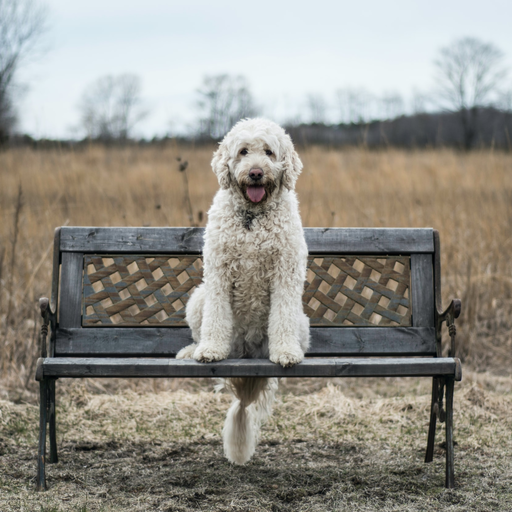

In [4]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
org_image = download_image(img_url).resize((512, 512))
org_image

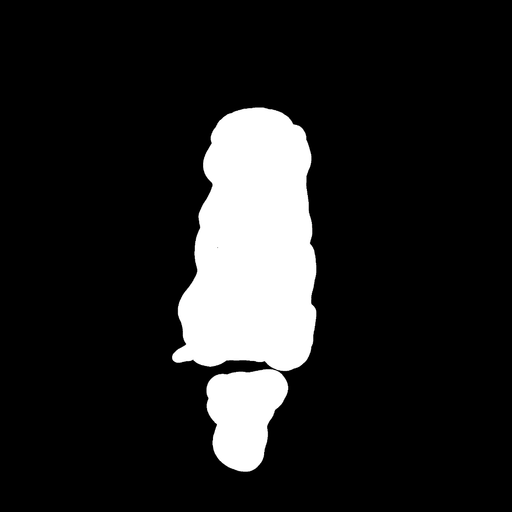

In [5]:
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
mask_image = download_image(mask_url).resize((512, 512))
mask_image

In [6]:
# Tokenize the text and generate the embeddings from the prompt
text_inputs = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
print(text_inputs.input_ids.shape)
# input_ids: List of token ids to be fed to a model.

with torch.no_grad():
    prompt_embeds = text_encoder(text_inputs.input_ids.to(device))
    prompt_embeds = prompt_embeds[0]

    bs_embed, seq_len, _ = prompt_embeds.shape
    print(bs_embed, seq_len)

    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

max_length = prompt_embeds.shape[1]
uncond_input = tokenizer(
    negative_prompt,
    padding="max_length",
    max_length=max_length,
    truncation=True,
    return_tensors="pt",
)

with torch.no_grad():
    negative_prompt_embeds = text_encoder(uncond_input.input_ids.to(device))
    negative_prompt_embeds = negative_prompt_embeds[0]

    seq_len = negative_prompt_embeds.shape[1]

    negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds.dtype, device=device)
    negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
    negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

print(prompt_embeds.shape)

torch.Size([1, 77])
1 77
torch.Size([2, 77, 768])


In [8]:
# Preprocess initial image
org_images = [org_image]
org_images = [np.array(image).astype(np.float32) / 255.0 for image in org_images]
org_images = np.stack(org_images, axis=0)
org_images = torch.from_numpy(org_images.transpose(0, 3, 1, 2))
org_images = 2.0 * org_images - 1.0

init_image = org_images.to(dtype=torch.float32)

In [9]:
# Preprocess mask image
mask_images = [mask_image]
mask_images = [image.convert("L") for image in mask_images]
mask_images = [np.array(image).astype(np.float32) / 255.0 for image in mask_images]
mask_images = np.stack(mask_images, axis=0)
mask_images = mask_images[..., None]
mask_images = torch.from_numpy(mask_images.transpose(0, 3, 1, 2))
mask_images[mask_images < 0.5] = 0
mask_images[mask_images >= 0.5] = 1

mask_condition = mask_images.to(dtype=torch.float32)

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [10]:
# prepare_latents
from diffusers.utils.torch_utils import randn_tensor

shape = (batch_size * num_images_per_prompt, unet.in_channels, height // 8, width // 8)

image = init_image.to(device=device, dtype=torch_dtype)

# Encode image with VAE
encoder_output = vae.encode(image)
image_latents = encoder_output.latent_dist.sample(generator)
image_latents = vae.config.scaling_factor * image_latents  # scaling_factor = 0.18215

noise = randn_tensor(shape, generator=generator, device=device, dtype=torch_dtype)

is_strength_max = strength == 1.0

latent_timestep = scheduler.timesteps[:1].repeat(batch_size * num_images_per_prompt)

latents = noise if is_strength_max else scheduler.add_noise(image_latents, noise, latent_timestep)
# if pure noise then scale the initial latents by the  Scheduler's init sigma
latents = latents * scheduler.init_noise_sigma if is_strength_max else latents

print("noise shape:", noise.shape)
print("latents shape:", latents.shape)

/var/folders/yz/4wsq420d7mv8024lyh9jyb5h0000gn/T/ipykernel_72789/365464896.py:4: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  shape = (batch_size * num_images_per_prompt, unet.in_channels, height // 8, width // 8)


noise shape: torch.Size([1, 4, 64, 64])
latents shape: torch.Size([1, 4, 64, 64])


In [11]:
masked_image = init_image * (mask_condition < 0.5)

# prepare_mask_latents
mask = torch.nn.functional.interpolate(
    mask_images, size=(height // 8, width // 8)
)
mask = mask.to(device=device, dtype=torch_dtype)
masked_image = masked_image.to(device=device, dtype=torch_dtype)

# Encode mask image with VAE
encoder_output = vae.encode(masked_image)
masked_image_latents = encoder_output.latent_dist.sample(generator)
masked_image_latents = vae.config.scaling_factor * masked_image_latents  # scaling_factor = 0.18215

mask = mask.repeat(batch_size // mask.shape[0], 1, 1, 1)
masked_image_latents = masked_image_latents.repeat(batch_size // masked_image_latents.shape[0], 1, 1, 1)

mask = torch.cat([mask] * 2)
masked_image_latents = torch.cat([masked_image_latents] * 2)

# aligning device to prevent device errors when concating it with the latent model input
masked_image_latents = masked_image_latents.to(device=device, dtype=torch_dtype)

num_channels_unet = unet.config.in_channels
if num_channels_unet == 9:
    # default case for runwayml/stable-diffusion-inpainting
    num_channels_mask = mask.shape[1]
    num_channels_masked_image = masked_image_latents.shape[1]

print("mask_condition shape:", mask_condition.shape)
print("masked_image shape:", masked_image.shape)
print("mask shape:", mask.shape)
print("masked_image_latents shape:", masked_image_latents.shape)

mask_condition shape: torch.Size([1, 1, 512, 512])
masked_image shape: torch.Size([1, 3, 512, 512])
mask shape: torch.Size([2, 1, 64, 64])
masked_image_latents shape: torch.Size([2, 4, 64, 64])


The last step is to create the denoising loop that’ll progressively transform the pure noise in latents to an image

In [12]:
from tqdm.auto import tqdm

# Set the scheduler’s timesteps to use during denoising.
# This will compute the `sigmas` and exact time step values to be used
# during the denoising process.
scheduler.set_timesteps(num_inference_steps, device=device)

with torch.no_grad():
    for i, t in enumerate(tqdm(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        if num_channels_unet == 9:
            latent_model_input = torch.cat([latent_model_input, mask, masked_image_latents], dim=1)

        print(f"{t} - latents: {latents.shape} {latents.dtype} {latents.device}", end="")
        print(f" / latent_model_input: {latent_model_input.shape} {latent_model_input.dtype} {latent_model_input.device}", end="")
        print(f" / prompt_embeds: {prompt_embeds.shape} {prompt_embeds.dtype} {prompt_embeds.device}", end="")
        print(f" / unet: {unet.device}", end="")

        # predict the noise residual
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            return_dict=False,
        )[0]

        print(f" @ Unet Done.")

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]
        if num_channels_unet == 4:
            init_latents_proper = image_latents
            init_mask, _ = mask.chunk(2)

            if i < len(scheduler.timesteps) - 1:
                noise_timestep = scheduler.timesteps[i + 1]
                init_latents_proper = scheduler.add_noise(
                    init_latents_proper, noise, torch.tensor([noise_timestep])
                )

            latents = (1 - init_mask) * init_latents_proper + init_mask * latents


  0%|          | 0/25 [00:00<?, ?it/s]

961 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 @ Unet Done.


  4%|▍         | 1/25 [00:19<07:38, 19.10s/it]

921 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

  8%|▊         | 2/25 [00:20<03:18,  8.65s/it]

 @ Unet Done.
881 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 12%|█▏        | 3/25 [00:21<01:50,  5.02s/it]

 @ Unet Done.
841 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 16%|█▌        | 4/25 [00:21<01:09,  3.31s/it]

 @ Unet Done.
801 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 20%|██        | 5/25 [00:22<00:47,  2.37s/it]

 @ Unet Done.
761 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 24%|██▍       | 6/25 [00:23<00:34,  1.80s/it]

 @ Unet Done.
721 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 28%|██▊       | 7/25 [00:24<00:26,  1.49s/it]

 @ Unet Done.
681 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 32%|███▏      | 8/25 [00:24<00:20,  1.23s/it]

 @ Unet Done.
641 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 36%|███▌      | 9/25 [00:25<00:16,  1.06s/it]

 @ Unet Done.
601 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 40%|████      | 10/25 [00:26<00:14,  1.06it/s]

 @ Unet Done.
561 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 44%|████▍     | 11/25 [00:26<00:12,  1.16it/s]

 @ Unet Done.
521 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 48%|████▊     | 12/25 [00:27<00:10,  1.24it/s]

 @ Unet Done.
481 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 52%|█████▏    | 13/25 [00:28<00:09,  1.30it/s]

 @ Unet Done.
441 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 56%|█████▌    | 14/25 [00:28<00:08,  1.33it/s]

 @ Unet Done.
401 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 60%|██████    | 15/25 [00:29<00:07,  1.37it/s]

 @ Unet Done.
361 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 64%|██████▍   | 16/25 [00:30<00:06,  1.39it/s]

 @ Unet Done.
321 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 68%|██████▊   | 17/25 [00:30<00:05,  1.38it/s]

 @ Unet Done.
281 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 72%|███████▏  | 18/25 [00:31<00:05,  1.36it/s]

 @ Unet Done.
241 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 76%|███████▌  | 19/25 [00:32<00:04,  1.35it/s]

 @ Unet Done.
201 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 80%|████████  | 20/25 [00:33<00:04,  1.22it/s]

 @ Unet Done.
161 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 84%|████████▍ | 21/25 [00:34<00:03,  1.24it/s]

 @ Unet Done.
121 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 88%|████████▊ | 22/25 [00:35<00:02,  1.25it/s]

 @ Unet Done.
81 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 92%|█████████▏| 23/25 [00:35<00:01,  1.25it/s]

 @ Unet Done.
41 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

 96%|█████████▌| 24/25 [00:36<00:00,  1.27it/s]

 @ Unet Done.
1 - latents: torch.Size([1, 4, 64, 64]) torch.float32 mps:0 / latent_model_input: torch.Size([2, 4, 64, 64]) torch.float32 mps:0 / prompt_embeds: torch.Size([2, 77, 768]) torch.float32 mps:0 / unet: mps:0

100%|██████████| 25/25 [00:37<00:00,  1.49s/it]

 @ Unet Done.


We now use the `vae` to decode the generated `latents` back into the image.

In [16]:
# scale and decode the image latents with vae
# vae.config.scaling_factor = 0.18215 for SD 1.5
with torch.no_grad():
    image = vae.decode(1 / vae.config.scaling_factor * latents, return_dict=False, generator=generator)[0]

print(image.shape)

torch.Size([1, 3, 512, 512])


And finally, let's convert the image to PIL so we can display or save it.

(1, 512, 512, 3)


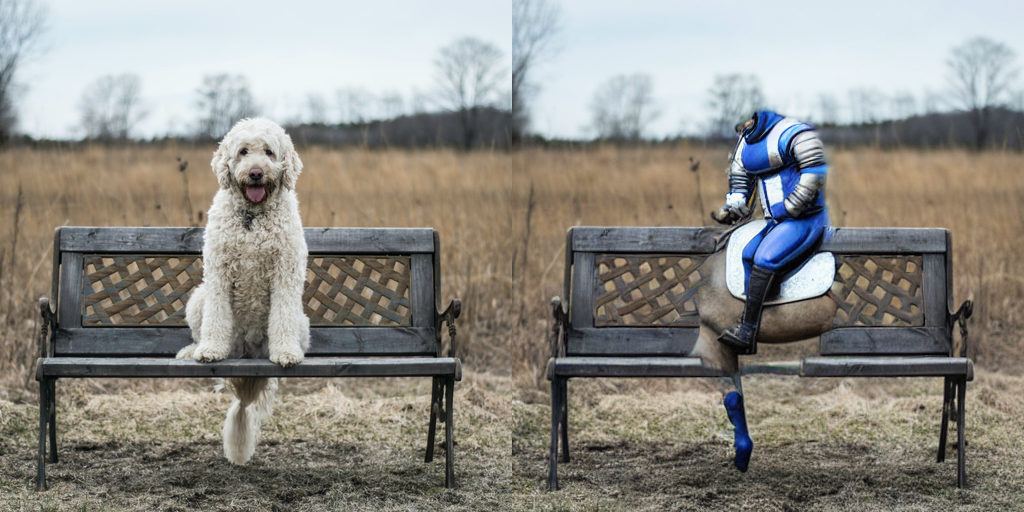

In [19]:
image_denorm = (image / 2 + 0.5).clamp(0, 1)
image_np = image_denorm.detach().cpu().permute(0, 2, 3, 1).numpy()

print(image_np.shape)

images = (image_np * 255).round().astype("uint8")
pil_images = [Image.fromarray(img) for img in images]

pil_images.insert(0, org_image)

grid = image_grid(pil_images, 1, num_images_per_prompt + 1)

# Display the image
grid
